# **Step 4 : Topic Modeling (LDA)**

**Goal**: Identify the latent dominant themes in the corpus

**Method**: Latent Dirichlet Allocation (LDA)

**Analyses performed**:
1. Preparation of data for LDA
2. Determination of the optimal number of topics (2-10)
3. Training of the LDA model
4. Extraction and interpretation of topics
5. Distribution of topics per document
6. Comparative analysis by source type (Consulting vs Academic vs Industry)
7. Visualizations (pyLDAvis, bar charts, heatmaps)

**Output**: Topics identified + visualizations for report

## Setup Config & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import pickle
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LDA & topic modeling
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Utilities
from tqdm.notebook import tqdm

# Viz Config
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✔ Imports")

✔ Imports


c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


## Load processed corpus

In [2]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
CORPUS_FILE = PROCESSED_DATA / "preprocessed_corpus.pkl"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create folder for topic modeling results
TOPICS_DIR = PROCESSED_DATA / "topics"
TOPICS_DIR.mkdir(exist_ok=True)

print(f"Topic modeling folder : {TOPICS_DIR}")

Topic modeling folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics


In [3]:
# Load processed corpus
with open(CORPUS_FILE, 'rb') as f:
    processed_corpus = pickle.load(f)

# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"✔ {len(processed_corpus)} documents loaded")

✔ 20 documents loaded


In [4]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in processed_corpus.keys()}

print(f"\nType distribution:")
for source_type, count in Counter(doc_to_source.values()).items():
    print(f"  • {source_type:15} : {count} document(s)")


Type distribution:
  • Consulting      : 7 document(s)
  • Industry        : 5 document(s)
  • Academic        : 4 document(s)
  • Policy          : 4 document(s)


## Data preparation for LDA

In [5]:
# Extract each doc tokens
documents_tokens = []
doc_ids_ordered = []

for doc_id, doc_data in processed_corpus.items():
    documents_tokens.append(doc_data['tokens'])
    doc_ids_ordered.append(doc_id)

print(f"\n✔ {len(documents_tokens)} documents prepared")


✔ 20 documents prepared


In [6]:
# Create dictionary (vocabulary)
dictionary = corpora.Dictionary(documents_tokens)

print(f"\nGensim dictionary created:")
print(f"   Initial vocabulary size : {len(dictionary)} words")


Gensim dictionary created:
   Initial vocabulary size : 10211 words


In [7]:
# Filter extremums
# no_below: min docs where the word must exist
# no_above: max proportion of documents (avoid overly common words)
dictionary.filter_extremes(no_below=2, no_above=0.7)
print(f"   After filtering      : {len(dictionary)} words")

   After filtering      : 3205 words


In [8]:
# Create corpus (bag-of-words)
corpus_bow = [dictionary.doc2bow(doc) for doc in documents_tokens]

print(f"\n✔ Bag-of-Words corpus created ({len(corpus_bow)} documents)")


✔ Bag-of-Words corpus created (20 documents)


In [9]:
# Sample
print(f"\nExample (1rst document):")
print(f"   Number of unique tokens: {len(corpus_bow[0])}")
print(f"   First 5 terms:")
for word_id, count in corpus_bow[0][:5]:
    print(f"      {dictionary[word_id]:20} : {count} occurrences")


Example (1rst document):
   Number of unique tokens: 1736
   First 5 terms:
      able                 : 4 occurrences
      academic             : 2 occurrences
      accelerate           : 17 occurrences
      accelerator          : 1 occurrences
      accept               : 1 occurrences


## Topics optimal number determination

### Using coherence score

In [10]:
# Try different topic numbers
topic_range = range(2, 11)  # 2~10 topics
coherence_scores = []

for num_topics in tqdm(topic_range, desc="Testing topic counts"):
    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus_bow,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        iterations=100,
        alpha='auto',
        per_word_topics=True
    )
    
    # Coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=documents_tokens,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"  {num_topics} topics: coherence = {coherence_score:.4f}")

print("\n✔ Computation of coherence scores completed")

Testing topic counts:   0%|          | 0/9 [00:00<?, ?it/s]

  2 topics: coherence = 0.3997
  3 topics: coherence = 0.4202
  4 topics: coherence = 0.4878
  5 topics: coherence = 0.4375
  6 topics: coherence = 0.4391
  7 topics: coherence = 0.4365
  8 topics: coherence = 0.4311
  9 topics: coherence = 0.4630
  10 topics: coherence = 0.4142

✔ Computation of coherence scores completed


In [11]:
# Find optimal number
optimal_num_topics = list(topic_range)[np.argmax(coherence_scores)]

print(f"\nOptimal number of topics (max coherence): {optimal_num_topics}")


Optimal number of topics (max coherence): 4


c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


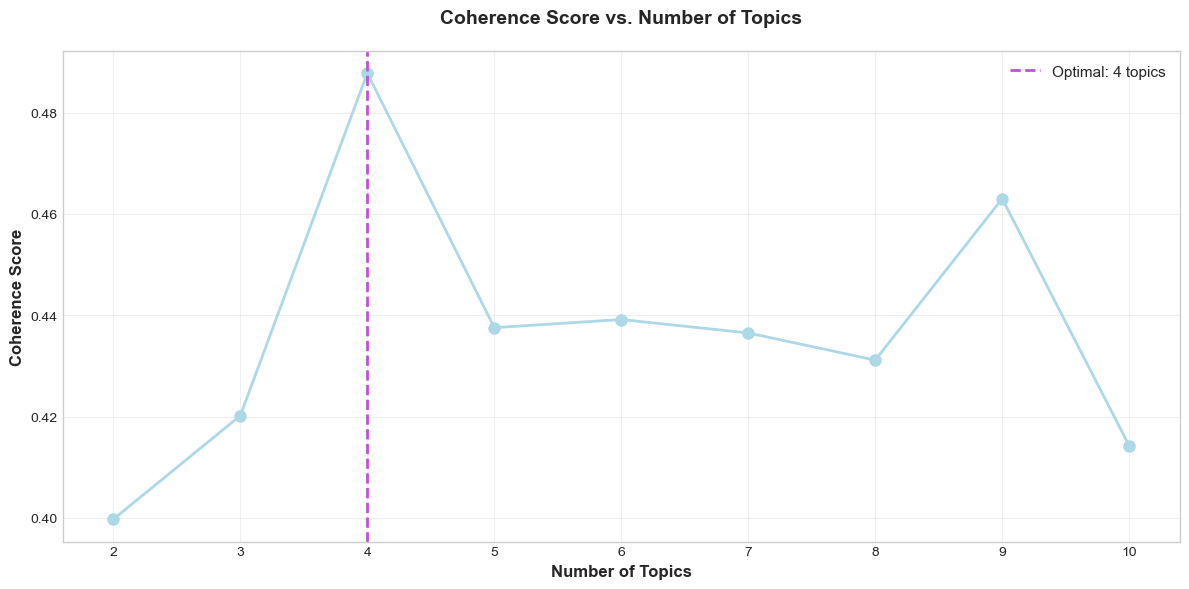


✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\coherence_scores.png


In [12]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(topic_range, coherence_scores, marker='o', linewidth=2, markersize=8, color='lightblue')
ax.axvline(x=optimal_num_topics, color='mediumorchid', linestyle='--', linewidth=2, 
           label=f'Optimal: {optimal_num_topics} topics')

ax.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax.set_ylabel('Coherence Score', fontsize=12, fontweight='bold')
ax.set_title('Coherence Score vs. Number of Topics', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(topic_range)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'coherence_scores.png', bbox_inches='tight')
plt.show()

print(f"\n✔ Graph saved to: {TOPICS_DIR / 'coherence_scores.png'}")

### Using manual determination (if necessary)

In [13]:
# Possibilité d'override manuel basé sur l'interprétabilité
# Par défaut, on utilise le nombre optimal trouvé
# Mais tu peux choisir manuellement si les topics ne sont pas interprétables

MANUAL_OVERRIDE = None  # Put a number (ex: 5, 6, 7) to force

if MANUAL_OVERRIDE:
    final_num_topics = MANUAL_OVERRIDE
    print(f"\nWARNING: Manual override: use of {final_num_topics} topics")
else:
    final_num_topics = optimal_num_topics
    print(f"\n✔ Use of optimal number: {final_num_topics} topics")


✔ Use of optimal number: 4 topics


## LDA model training

In [14]:
lda_model_final = LdaModel(
    corpus=corpus_bow,
    id2word=dictionary,
    num_topics=final_num_topics,
    random_state=42,
    passes=20,           # More passes for better training
    iterations=200,      # More iterations
    alpha='auto',        # Alpha auto
    eta='auto',          # Eta auto
    per_word_topics=True
)

print("\n✔ LDA model trained")


✔ LDA model trained


In [15]:
# Compute perplexity (lower = better)
perplexity = lda_model_final.log_perplexity(corpus_bow)
print(f"   Perplexity: {perplexity:.4f}")

   Perplexity: -7.4404


In [16]:
# Compute final coherence score
coherence_model_final = CoherenceModel(
    model=lda_model_final,
    texts=documents_tokens,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_final = coherence_model_final.get_coherence()
print(f"   Coherence:  {coherence_final:.4f}")

   Coherence:  0.4805


In [17]:
# Save model
lda_model_final.save(str(TOPICS_DIR / 'lda_model.model'))
dictionary.save(str(TOPICS_DIR / 'dictionary.dict'))
print(f"\n✔ Model saved to: {TOPICS_DIR / 'lda_model.model'}")


✔ Model saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_model.model


## Topics extraction and interpretation

In [18]:
# Extract topics
topics_data = []

for topic_id in range(final_num_topics):
    # Top 15 topic words
    topic_words = lda_model_final.show_topic(topic_id, topn=15)
    
    print(f"TOPIC {topic_id}")
    
    words_str = []
    for word, prob in topic_words:
        print(f"  {word:20} : {prob:.4f}")
        words_str.append(f"{word} ({prob:.3f})")
    
    topics_data.append({
        'topic_id': topic_id,
        'top_words': ', '.join([w for w, p in topic_words[:10]]),
        'words_detailed': words_str
    })

TOPIC 0
  evaluation           : 0.0080
  practice             : 0.0063
  foundation           : 0.0057
  autonomy             : 0.0051
  artificial           : 0.0039
  world                : 0.0038
  output               : 0.0037
  llm                  : 0.0035
  reason               : 0.0035
  developer            : 0.0035
  organization         : 0.0035
  harm                 : 0.0034
  responsible          : 0.0034
  definition           : 0.0034
  assessment           : 0.0033
TOPIC 1
  organization         : 0.0320
  leader               : 0.0098
  employee             : 0.0084
  say                  : 0.0078
  adopt                : 0.0076
  investment           : 0.0070
  emerge               : 0.0060
  survey               : 0.0058
  extensive            : 0.0058
  respondent           : 0.0056
  organizational       : 0.0056
  executive            : 0.0054
  worker               : 0.0051
  year                 : 0.0048
  strategic            : 0.0048
TOPIC 2
  workflow      

## Topics manual labellisation

In [43]:
# # Based on key words, we assign interpretable labels to topics
# # NEED TO UPDATE THIS SECTION FOR EACH NEW RESULT

# # Mapping by default
# TOPIC_LABELS = {
#     0: "Productivity & ROI",
#     1: "Workforce Transformation",
#     2: "Governance & Compliance",
#     3: "Technical Architecture & Infrastructure",
#     4: "Autonomous Work Orchestration",
#     5: "AI Models & Algorithms",
#     6: "Business Strategy & Implementation",
#     7: "Human-AI Collaboration"
# }

In [44]:
TOPIC_LABELS = {
    0: "AI Foundations & Responsible Development",
    1: "Organizational Adoption & Workforce Transformation",
    2: "Technology Products & Workflows",
    3: "Business Strategy & Sales"
}

In [45]:
# Use only existing labels
topic_labels_final = {k: v for k, v in TOPIC_LABELS.items() if k < final_num_topics}

# If missing labels, create automatically
for topic_id in range(final_num_topics):
    if topic_id not in topic_labels_final:
        top_words = [w for w, p in lda_model_final.show_topic(topic_id, topn=3)]
        topic_labels_final[topic_id] = f"Topic {topic_id}: {', '.join(top_words)}"

print("\nAssigned labels:")
for topic_id, label in topic_labels_final.items():
    print(f"  Topic {topic_id}: {label}")


Assigned labels:
  Topic 0: AI Foundations & Responsible Development
  Topic 1: Organizational Adoption & Workforce Transformation
  Topic 2: Technology Products & Workflows
  Topic 3: Business Strategy & Sales


In [46]:
# Add labels to DataFrame
for item in topics_data:
    item['label'] = topic_labels_final[item['topic_id']]

df_topics = pd.DataFrame(topics_data)

## Topics viz (Key words)

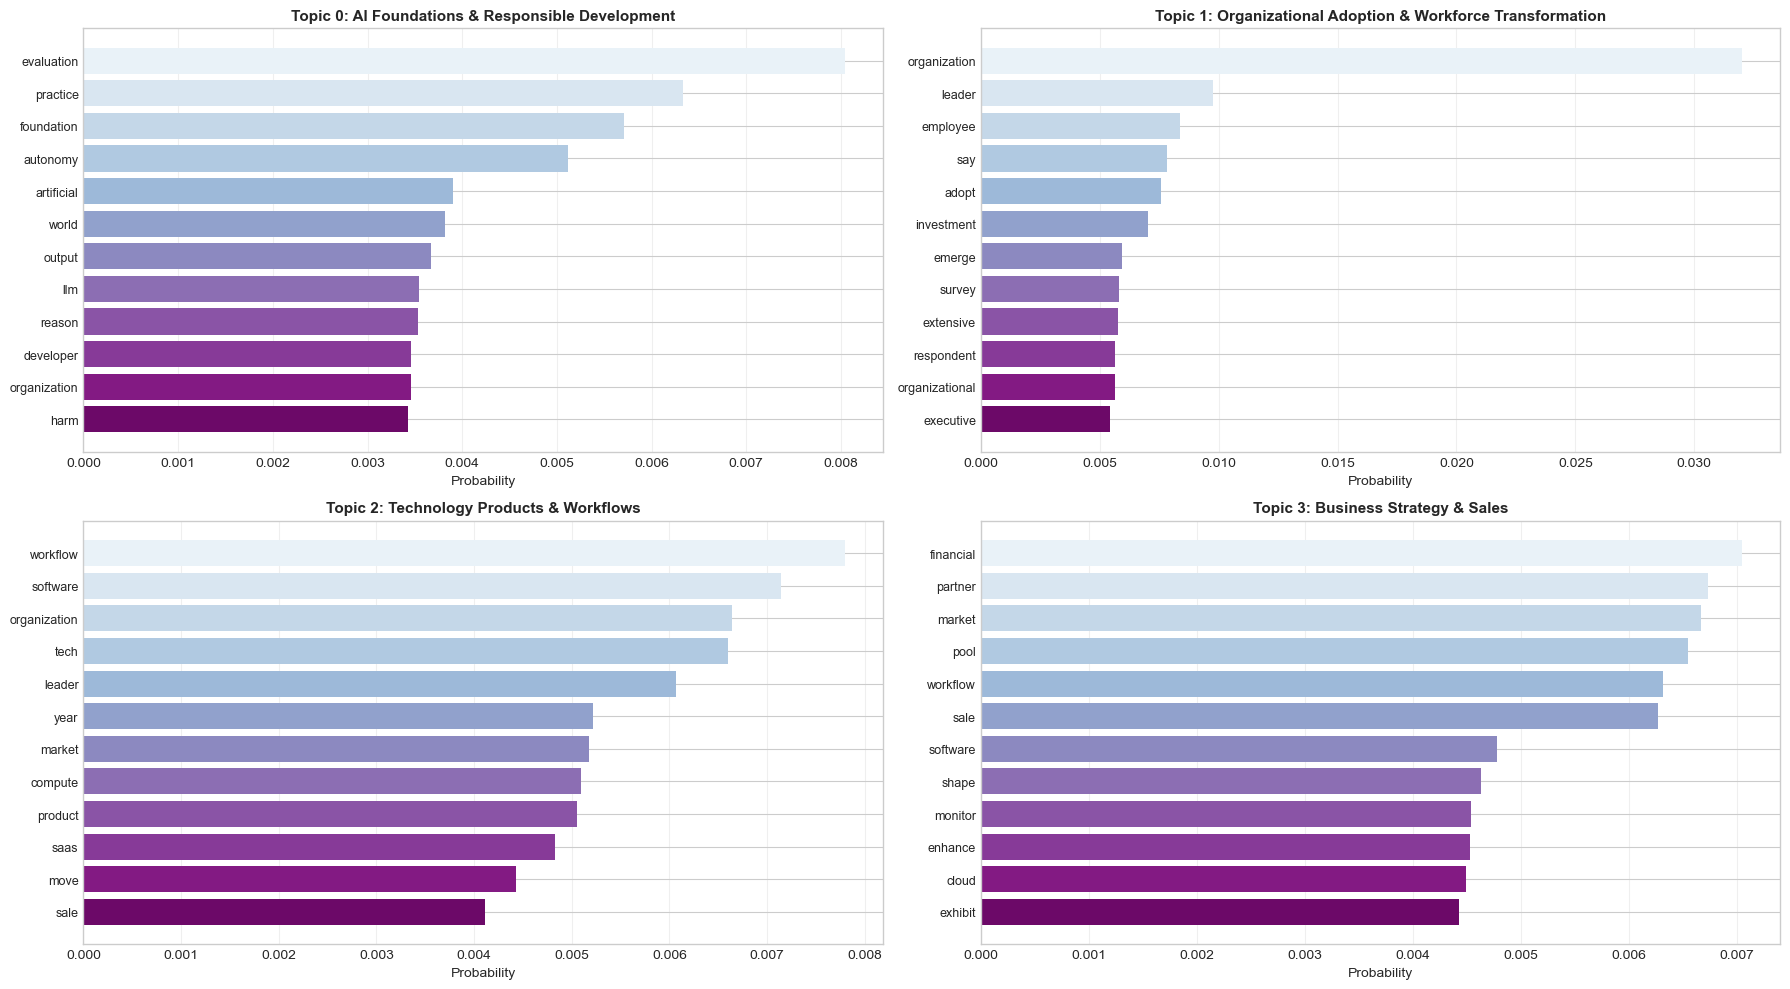

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_keywords.png


In [47]:
n_topics = final_num_topics
n_cols = 2
n_rows = (n_topics + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_topics > 1 else [axes]

for topic_id in range(n_topics):
    ax = axes[topic_id]
    
    # Words + proba
    topic_words = lda_model_final.show_topic(topic_id, topn=12)
    words = [w for w, p in topic_words]
    probs = [p for w, p in topic_words]
    
    # Plotting
    colors = sns.color_palette('BuPu', len(words))
    ax.barh(range(len(words)), probs, color=colors)
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Probability', fontsize=10)
    ax.set_title(f'Topic {topic_id}: {topic_labels_final[topic_id]}', 
                fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# Remove empty axes if odd number of topics
if n_topics % 2 == 1:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topics_keywords.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {TOPICS_DIR / 'topics_keywords.png'}")

## Topics per document distribution

In [48]:
# Topics distribution for each document
doc_topics_data = []

for doc_idx, doc_id in enumerate(doc_ids_ordered):
    # Topic distribution for doc
    topic_dist = lda_model_final.get_document_topics(corpus_bow[doc_idx])
    
    # Convert to dictionary (including prob=0 topics)
    topic_dict = {i: 0.0 for i in range(final_num_topics)}
    for topic_id, prob in topic_dist:
        topic_dict[topic_id] = prob
    
    # Find dominant topic
    dominant_topic = max(topic_dict.items(), key=lambda x: x[1])[0]
    
    doc_topics_data.append({
        'doc_id': doc_id,
        'filename': metadata[doc_id]['filename'],
        'source_type': doc_to_source[doc_id],
        'dominant_topic': dominant_topic,
        'dominant_topic_label': topic_labels_final[dominant_topic],
        **{f'topic_{i}': prob for i, prob in topic_dict.items()}
    })

df_doc_topics = pd.DataFrame(doc_topics_data)
df_doc_topics.head() # Check

,doc_id,filename,source_type,dominant_topic,dominant_topic_label,topic_0,topic_1,topic_2,topic_3
0,Bain_report_technology_report_2025,Bain_report_technology_report_2025.pdf,Consulting,2,Technology Products & Workflows,0.000000,0.000000,0.999972,0.000000
1,BCG_AI_Agents_2025,BCG_AI_Agents_2025.pdf,Consulting,0,AI Foundations & Responsible Development,0.463014,0.000000,0.290765,0.246129
2,Deloitte_The_business_imperative_for_Agentic_A...,Deloitte_The_business_imperative_for_Agentic_A...,Consulting,0,AI Foundations & Responsible Development,0.487892,0.000000,0.036195,0.475880
3,Google_Agentic_AI_TAM_Analysis_2025,Google_Agentic_AI_TAM_Analysis_2025.pdf,Industry,3,Business Strategy & Sales,0.000000,0.000000,0.000000,0.999976
4,Google_The_ROI_of_AI_2025,Google_The_ROI_of_AI_2025.pdf,Industry,3,Business Strategy & Sales,0.000000,0.337467,0.300893,0.361340


In [49]:
print("\nDistribution per document (first documents):\n")
display_cols = ['filename', 'source_type', 'dominant_topic_label'] + \
               [f'topic_{i}' for i in range(final_num_topics)]

df_doc_topics[display_cols].head(10)


Distribution per document (first documents):



,filename,source_type,dominant_topic_label,topic_0,topic_1,topic_2,topic_3
0,Bain_report_technology_report_2025.pdf,Consulting,Technology Products & Workflows,0.000000,0.000000,0.999972,0.000000
1,BCG_AI_Agents_2025.pdf,Consulting,AI Foundations & Responsible Development,0.463014,0.000000,0.290765,0.246129
2,Deloitte_The_business_imperative_for_Agentic_A...,Consulting,AI Foundations & Responsible Development,0.487892,0.000000,0.036195,0.475880
3,Google_Agentic_AI_TAM_Analysis_2025.pdf,Industry,Business Strategy & Sales,0.000000,0.000000,0.000000,0.999976
4,Google_The_ROI_of_AI_2025.pdf,Industry,Business Strategy & Sales,0.000000,0.337467,0.300893,0.361340
5,Harvard_Designing_a_Successful_Agentic_AI_Syst...,Academic,Business Strategy & Sales,0.000000,0.211130,0.123440,0.665307
6,ITI_Understanding_Agentic_AI_Policy_Guide_2025...,Policy,AI Foundations & Responsible Development,0.944120,0.000000,0.000000,0.055819
7,McKinsey_Empowering_advanced_industries_with_a...,Consulting,Technology Products & Workflows,0.119865,0.047896,0.469002,0.363236
8,McKinsey_The_agentic_organization_contours_of_...,Consulting,Technology Products & Workflows,0.000000,0.093925,0.905985,0.000000
9,McKinsey_What_is_an_AI_Agent_2025.pdf,Consulting,Technology Products & Workflows,0.377001,0.045575,0.474850,0.102574


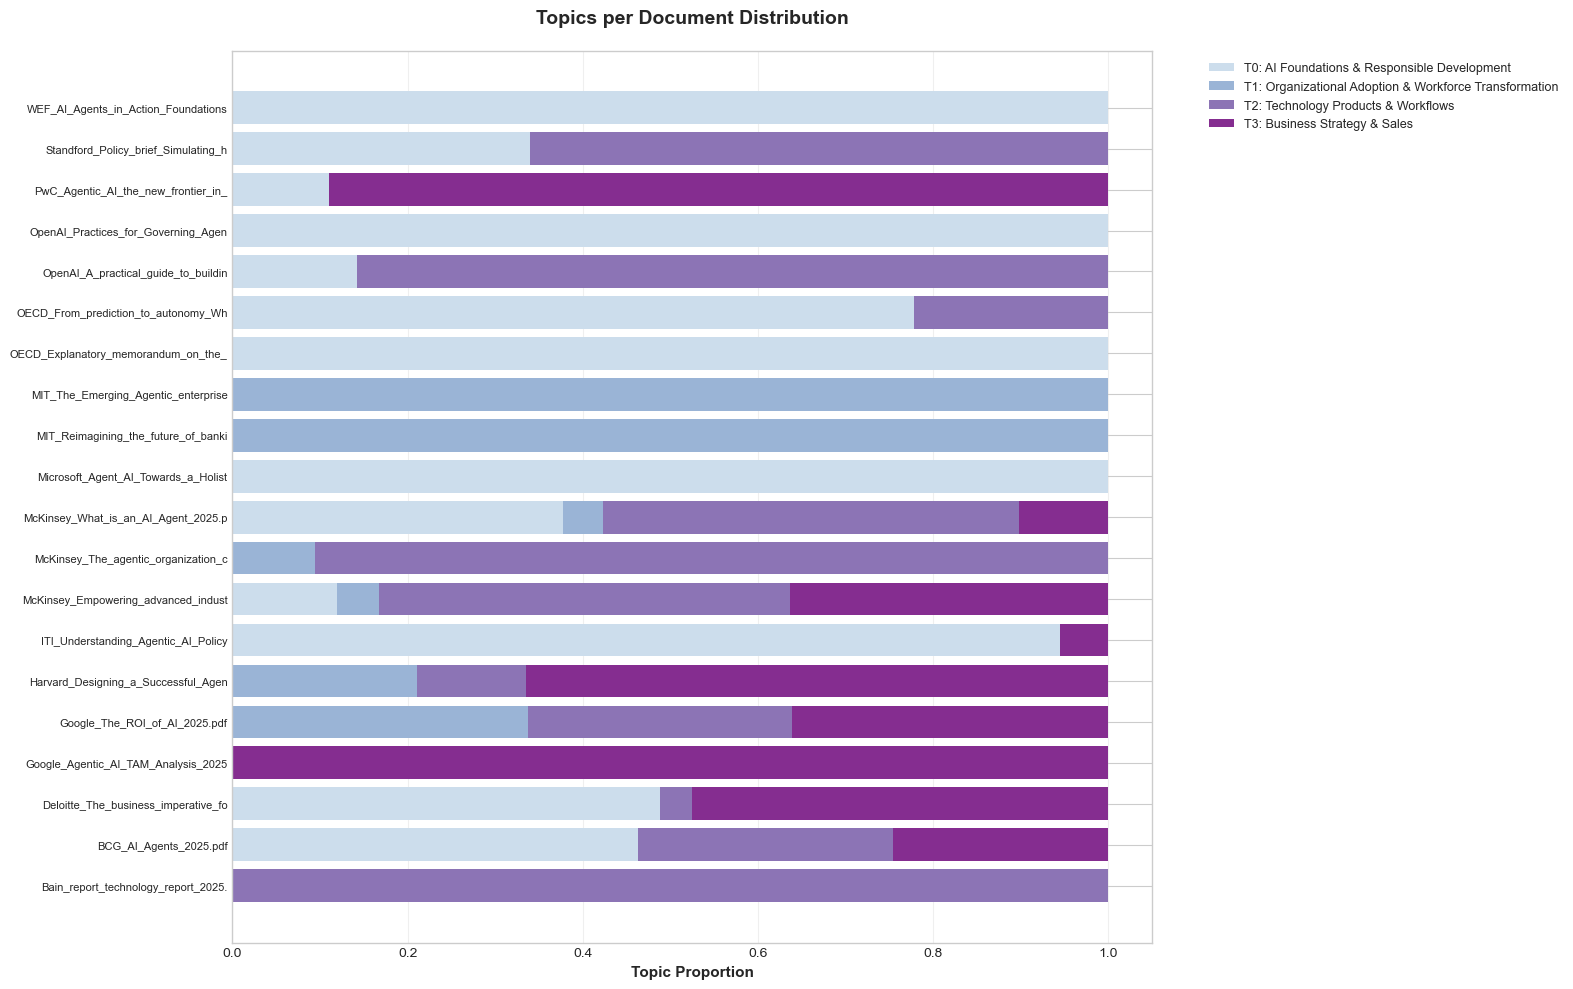

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topic_distribution_by_document.png


In [50]:
topic_columns = [f'topic_{i}' for i in range(final_num_topics)]
topic_data = df_doc_topics[topic_columns].values

fig, ax = plt.subplots(figsize=(16, 10))

# Create stacked bars
bottom = np.zeros(len(df_doc_topics))
# colors = plt.cm.Set3(np.linspace(0, 1, final_num_topics))
colors = sns.color_palette('BuPu', len(topic_columns))

for topic_id in range(final_num_topics):
    values = df_doc_topics[f'topic_{topic_id}'].values
    ax.barh(range(len(df_doc_topics)), values, left=bottom, 
           label=f'T{topic_id}: {topic_labels_final[topic_id]}',
           color=colors[topic_id])
    bottom += values

ax.set_yticks(range(len(df_doc_topics)))
ax.set_yticklabels(df_doc_topics['filename'].str[:35], fontsize=8)
ax.set_xlabel('Topic Proportion', fontsize=11, fontweight='bold')
ax.set_title('Topics per Document Distribution', fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topic_distribution_by_document.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {TOPICS_DIR / 'topic_distribution_by_document.png'}")

## Topics global distribution 

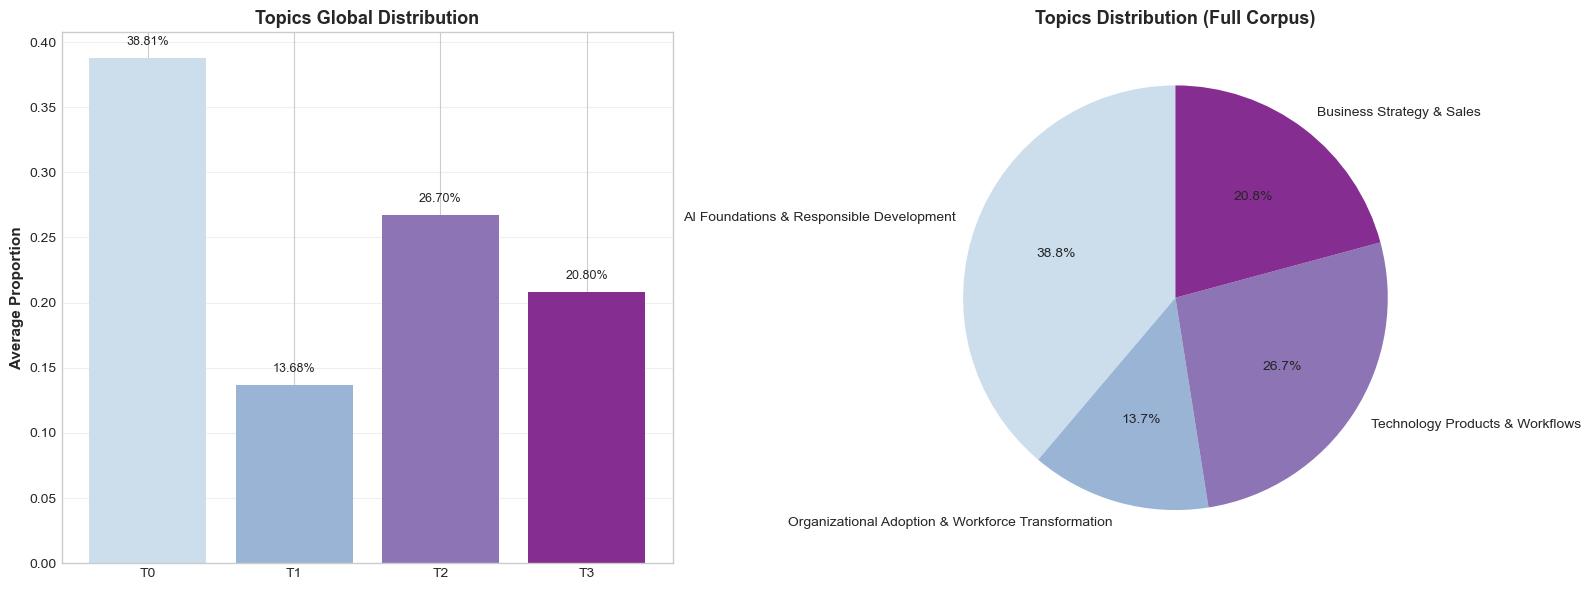

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topic_global_distribution.png


In [51]:
# Compute average proportion of each topic in corpus
topic_proportions = df_doc_topics[topic_columns].mean().values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
axes[0].bar(range(final_num_topics), topic_proportions, 
           color=colors, linewidth=1.5)
axes[0].set_xticks(range(final_num_topics))
axes[0].set_xticklabels([f'T{i}' for i in range(final_num_topics)])
axes[0].set_ylabel('Average Proportion', fontsize=11, fontweight='bold')
axes[0].set_title('Topics Global Distribution', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, prop in enumerate(topic_proportions):
    axes[0].text(i, prop + 0.01, f'{prop:.2%}', ha='center', fontsize=9)

# Pie chart
axes[1].pie(topic_proportions, 
           labels=[topic_labels_final[i] for i in range(final_num_topics)],
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Topics Distribution (Full Corpus)', 
                 fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topic_global_distribution.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {TOPICS_DIR / 'topic_global_distribution.png'}")

In [52]:
print("\nGlobal topic proportions:")
for i, prop in enumerate(topic_proportions):
    print(f"  {topic_labels_final[i]:40} : {prop:.1%}")


Global topic proportions:
  AI Foundations & Responsible Development : 38.8%
  Organizational Adoption & Workforce Transformation : 13.7%
  Technology Products & Workflows          : 26.7%
  Business Strategy & Sales                : 20.8%


## Comparative analysis per source type

In [53]:
# Compute average proportions per type
topic_by_source = df_doc_topics.groupby('source_type')[topic_columns].mean()

print("\nAverage topics proportions per source type:\n")
topic_by_source.round(3)


Average topics proportions per source type:



,topic_0,topic_1,topic_2,topic_3
source_type,,,,
Academic,0.085,0.553,0.196,0.166
Consulting,0.223,0.027,0.454,0.297
Industry,0.429,0.067,0.232,0.272
Policy,0.930,0.000,0.056,0.014


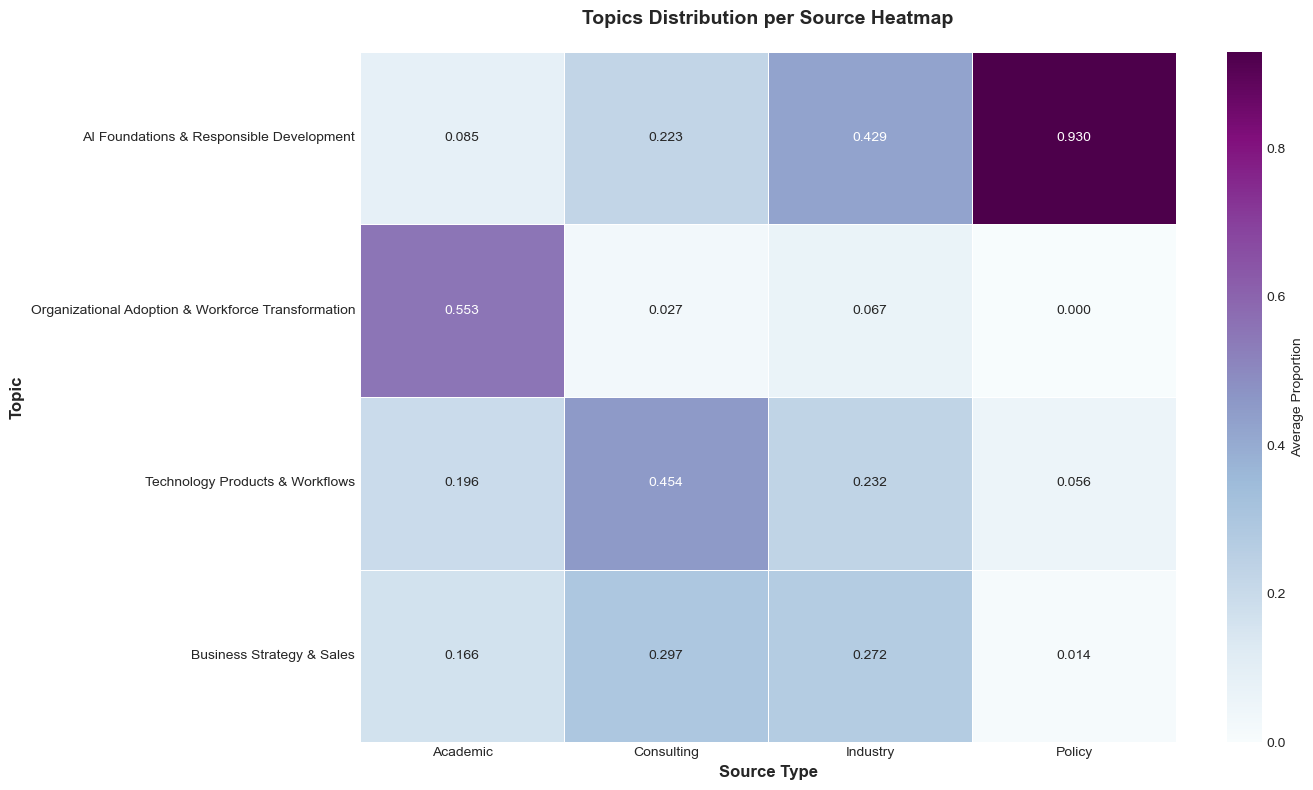

✔ Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\heatmap_topics_by_source.png


In [54]:
# Heatmap visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Rename columns
topic_by_source_labeled = topic_by_source.copy()
topic_by_source_labeled.columns = [topic_labels_final[i] for i in range(final_num_topics)]

sns.heatmap(topic_by_source_labeled.T, annot=True, fmt='.3f', cmap='BuPu',
           linewidths=0.5, cbar_kws={'label': 'Average Proportion'}, ax=ax)

ax.set_xlabel('Source Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Topics Distribution per Source Heatmap', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'heatmap_topics_by_source.png', bbox_inches='tight')
plt.show()

print(f"✔ Heatmap saved to: {TOPICS_DIR / 'heatmap_topics_by_source.png'}")

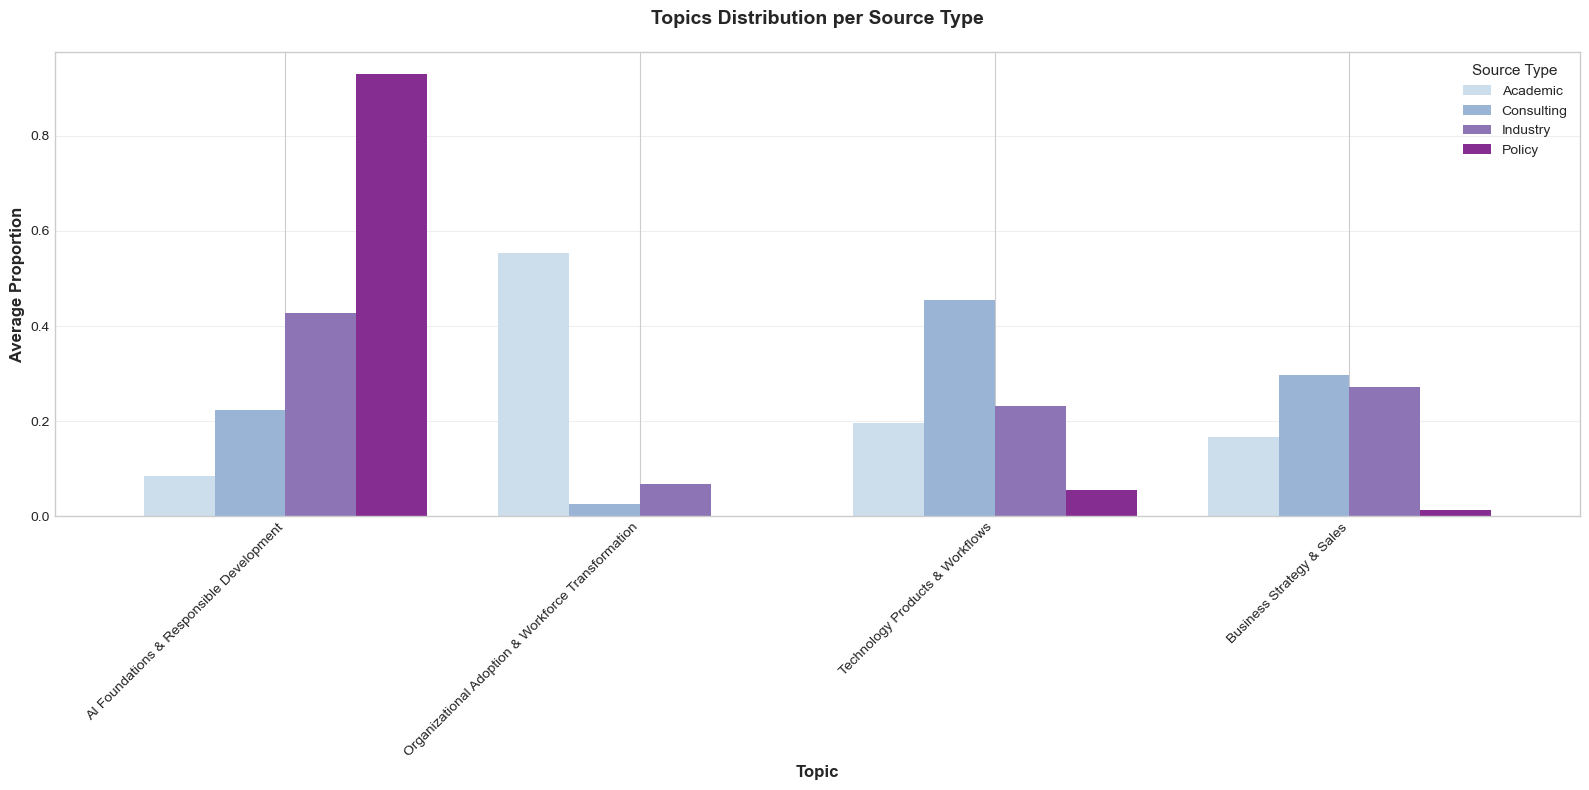

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_by_source_grouped.png


In [55]:
# Bar chart grouped
fig, ax = plt.subplots(figsize=(16, 8))

colors = sns.color_palette('BuPu', len(topic_by_source))

topic_by_source_labeled.T.plot(kind='bar', ax=ax, width=0.8, color=colors) ## colors[:len(topic_by_source)]

ax.set_ylabel('Average Proportion', fontsize=12, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Topics Distribution per Source Type', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Source Type', fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topics_by_source_grouped.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {TOPICS_DIR / 'topics_by_source_grouped.png'}")

## Dominant topic per source type

In [56]:
for source_type in topic_by_source.index:
    dominant_topic_id = topic_by_source.loc[source_type].idxmax()
    dominant_topic_id = int(dominant_topic_id.split('_')[1])
    proportion = topic_by_source.loc[source_type, f'topic_{dominant_topic_id}']
    
    print(f"\n{source_type}:")
    print(f"  Dominant topic : {topic_labels_final[dominant_topic_id]}")
    print(f"  Proportion     : {proportion:.1%}")


Academic:
  Dominant topic : Organizational Adoption & Workforce Transformation
  Proportion     : 55.3%

Consulting:
  Dominant topic : Technology Products & Workflows
  Proportion     : 45.4%

Industry:
  Dominant topic : AI Foundations & Responsible Development
  Proportion     : 42.9%

Policy:
  Dominant topic : AI Foundations & Responsible Development
  Proportion     : 93.0%


## Interactive viz using `pyLDAvis`

In [57]:
vis_data = gensimvis.prepare(lda_model_final, corpus_bow, dictionary, sort_topics=False)

# Save HTML
html_path = TOPICS_DIR / 'lda_visualization.html'
pyLDAvis.save_html(vis_data, str(html_path))

print(f"\n✔ Interactive visualization generated: {html_path}")
print(f"   Open file in browser to explore topics")

# Display in notebook (optional => too slow, would not recommend)
# pyLDAvis.display(vis_data)


✔ Interactive visualization generated: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_visualization.html
   Open file in browser to explore topics


## Save results

In [58]:
# Save topics with associated key words
df_topics.to_csv(TOPICS_DIR / 'topics_keywords.csv', index=False)
print(f"✔ Topics and key words saved to: {TOPICS_DIR / 'topics_keywords.csv'}")

✔ Topics and key words saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_keywords.csv


In [59]:
# Save distribution per document
df_doc_topics.to_csv(TOPICS_DIR / 'document_topic_distribution.csv', index=False)
print(f"✔ Distribution per document saved to: {TOPICS_DIR / 'document_topic_distribution.csv'}")

✔ Distribution per document saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\document_topic_distribution.csv


In [60]:
# Save proportions per type
topic_by_source.to_csv(TOPICS_DIR / 'topics_by_source_type.csv')
print(f"✔ Topics per type saved to: {TOPICS_DIR / 'topics_by_source_type.csv'}")

✔ Topics per type saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_by_source_type.csv


In [61]:
# Save results summary
summary = {
    'num_topics': final_num_topics,
    'coherence_score': float(coherence_final),
    'perplexity': float(perplexity),
    'topic_labels': topic_labels_final,
    'global_proportions': {topic_labels_final[i]: float(prop) 
                          for i, prop in enumerate(topic_proportions)}
}

with open(TOPICS_DIR / 'lda_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✔ Summary saved to: {TOPICS_DIR / 'lda_summary.json'}")

✔ Summary saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_summary.json


In [62]:
# Create textual report
report = f"""
{'='*70}
TOPIC MODELING (LDA) REPORT
{'='*70}

MODEL PARAMETERS
{'─'*70}
Number of topics    : {final_num_topics}
Coherence score     : {coherence_final:.4f}
Perplexity          : {perplexity:.4f}
Number of documents : {len(doc_ids_ordered)}

IDENTIFIED TOPICS
{'─'*70}
"""

for topic_id in range(final_num_topics):
    top_words = ', '.join([w for w, p in lda_model_final.show_topic(topic_id, topn=10)])
    report += f"\nTopic {topic_id}: {topic_labels_final[topic_id]}\n"
    report += f"  Key words: {top_words}\n"
    report += f"  Global proportion: {topic_proportions[topic_id]:.1%}\n"

report += f"\n{'─'*70}\n"
report += "DISTRIBUTION PER SOURCE TYPE\n"
report += f"{'─'*70}\n"

for source_type in topic_by_source.index:
    report += f"\n{source_type}:\n"
    for topic_id in range(final_num_topics):
        prop = topic_by_source.loc[source_type, f'topic_{topic_id}']
        if prop > 0.05:  # Display only if > 5%
            report += f"  • {topic_labels_final[topic_id]:40} : {prop:.1%}\n"

report += f"\n{'='*70}\n"

# Save report
report_path = TOPICS_DIR / 'lda_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✔ Textual report saved to: {report_path}")

✔ Textual report saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_report.txt


In [63]:
print("\n" + report) # Check format



TOPIC MODELING (LDA) REPORT

MODEL PARAMETERS
──────────────────────────────────────────────────────────────────────
Number of topics    : 4
Coherence score     : 0.4805
Perplexity          : -7.4404
Number of documents : 20

IDENTIFIED TOPICS
──────────────────────────────────────────────────────────────────────

Topic 0: AI Foundations & Responsible Development
  Key words: evaluation, practice, foundation, autonomy, artificial, world, output, llm, reason, developer
  Global proportion: 38.8%

Topic 1: Organizational Adoption & Workforce Transformation
  Key words: organization, leader, employee, say, adopt, investment, emerge, survey, extensive, respondent
  Global proportion: 13.7%

Topic 2: Technology Products & Workflows
  Key words: workflow, software, organization, tech, leader, year, market, compute, product, saas
  Global proportion: 26.7%

Topic 3: Business Strategy & Sales
  Key words: financial, partner, market, pool, workflow, sale, software, shape, monitor, enhance
  G

## Insights summary

In [64]:
print("\n✔ DOMINANTS TOPICS (Global):")
sorted_topics = sorted(enumerate(topic_proportions), key=lambda x: x[1], reverse=True)
for i, (topic_id, prop) in enumerate(sorted_topics[:3], 1):
    print(f"  {i}. {topic_labels_final[topic_id]:40} : {prop:.1%}")

print("\n✔ DIFFERENCES PER SOURCE TYPE:")
for source_type in topic_by_source.index:
    top_2_topics = topic_by_source.loc[source_type].nlargest(2)
    print(f"\n  {source_type}:")
    for topic_col in top_2_topics.index:
        topic_id = int(topic_col.split('_')[1])
        prop = top_2_topics[topic_col]
        print(f"    • {topic_labels_final[topic_id]:35} : {prop:.1%}")

print("\n✔ CONVERGENCE/DIVERGENCE:")
# Compute variance between types for each topic
topic_variances = []
for topic_id in range(final_num_topics):
    col = f'topic_{topic_id}'
    variance = topic_by_source[col].var()
    topic_variances.append((topic_id, variance))

# Topics with greatest variance = more divergence between types
sorted_by_variance = sorted(topic_variances, key=lambda x: x[1], reverse=True)

print("\n  Topics with STRONG divergence between types:")
for topic_id, var in sorted_by_variance[:3]:
    print(f"    • {topic_labels_final[topic_id]:35} (variance: {var:.4f})")

print("\n  Topics with WEAK divergence (consensus):")
for topic_id, var in sorted_by_variance[-3:]:
    print(f"    • {topic_labels_final[topic_id]:35} (variance: {var:.4f})")


✔ DOMINANTS TOPICS (Global):
  1. AI Foundations & Responsible Development : 38.8%
  2. Technology Products & Workflows          : 26.7%
  3. Business Strategy & Sales                : 20.8%

✔ DIFFERENCES PER SOURCE TYPE:

  Academic:
    • Organizational Adoption & Workforce Transformation : 55.3%
    • Technology Products & Workflows     : 19.6%

  Consulting:
    • Technology Products & Workflows     : 45.4%
    • Business Strategy & Sales           : 29.7%

  Industry:
    • AI Foundations & Responsible Development : 42.9%
    • Business Strategy & Sales           : 27.2%

  Policy:
    • AI Foundations & Responsible Development : 93.0%
    • Technology Products & Workflows     : 5.6%

✔ CONVERGENCE/DIVERGENCE:

  Topics with STRONG divergence between types:
    • AI Foundations & Responsible Development (variance: 0.1373)
    • Organizational Adoption & Workforce Transformation (variance: 0.0687)
    • Technology Products & Workflows     (variance: 0.0272)

  Topics with WEAK di

## Documents hierarchical clustering

In [65]:
# Use topics distributions as features
topic_features = df_doc_topics[topic_columns].values

# Compute cosine matrix
distances = pdist(topic_features, metric='cosine')

# Hierarchical linkage
linkage_matrix = linkage(distances, method='ward')

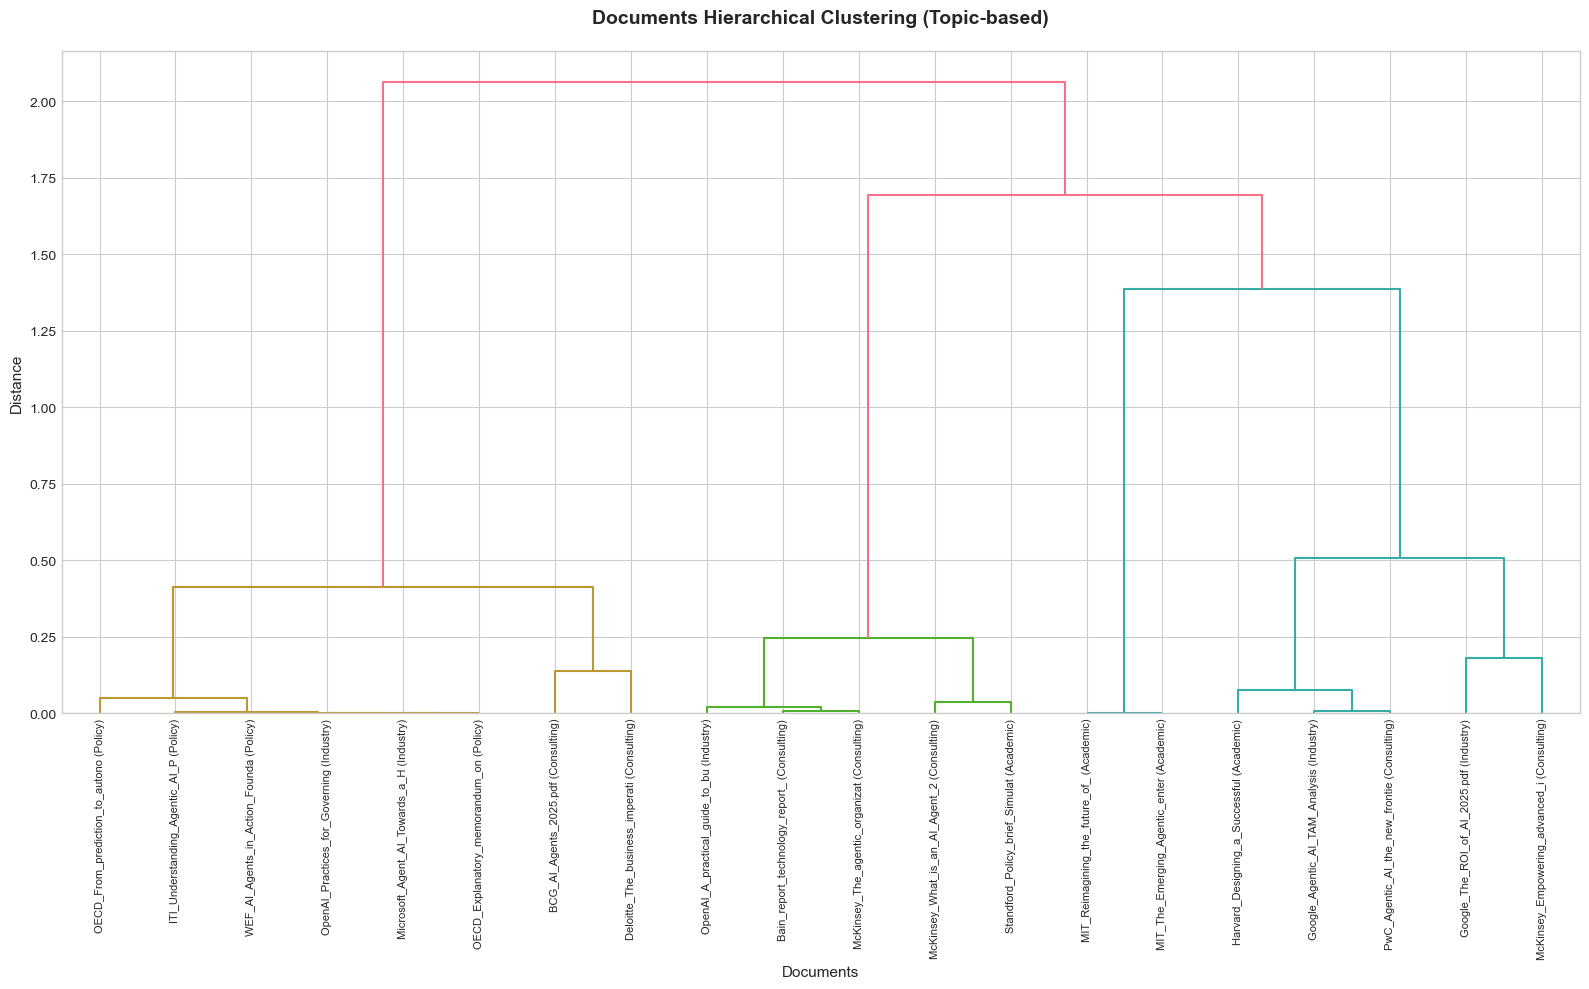

✔ Dendrogram saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\hierarchical_clustering.png


In [67]:
# Plotting
fig, ax = plt.subplots(figsize=(16, 10))

# Create labels (name + type)
labels = [f"{metadata[doc_id]['filename'][:30]} ({doc_to_source[doc_id]})" 
          for doc_id in doc_ids_ordered]

dendrogram(
    linkage_matrix,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax
)

ax.set_title('Documents Hierarchical Clustering (Topic-based)', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Documents', fontsize=11)
ax.set_ylabel('Distance', fontsize=11)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'hierarchical_clustering.png', bbox_inches='tight')
plt.show()

print(f"✔ Dendrogram saved to: {TOPICS_DIR / 'hierarchical_clustering.png'}")

Near documents = similar topics distributions, and clusters = groups of documents on similar themes